# Example 7

## 2D case with prior

**Content**

This notebook reproduces the first example of the paper. It consists of four main subheadings;

- Importing the *hcpinnseikonal* package functions
- Define the arguments for the input parameters
- Setup the medium and compute the data
- Training and inference

**Saving directory**

The notebook utilized [*wandb*](https://wandb.ai) for keeping track of the parameters and experiments. You can uncomment the *wandb* call to turn this feature off. Accordingly you need to specify the folder to save your experiment by changing the related *wandb* line inside the main function below.

## Formulation

### 2-D

The isotropic eikonal in 2-D (x-z medium) is given as,

$$|\nabla T(x, z)|^2 = \frac{1}{v^2(x, z)}.$$

What we aim for is a hard-constrained velocity prior version. In 2-D medium with $i$ denotes the index for the well, we have $x_{wi}, v(x=x_{wi},z)=v_{wi}(z)$ to denote the well location and velocity values, respectively. Therefore, for three wells, we have the following form of the right hand side of the eikonal

$$v(x,z) = \left(\prod_{i=1}^3 {\left(x - \mathit{x_{wi}}\right)} \right)v_{\theta}\left(x, z\right) + \sum_{i=1}^3\left(\prod_{j\neq i}^3\frac{x-x_{wj}}{x_{wi}-x_{wj}}\right){v_{wi}(z)}.$$

The first part is parameterized by the neural network $v_{\theta}\left(x, z\right)$ while the second part contains the well information.

### 3-D

Therefore, for 3-D, with $N$ number of wells, we can expand the above formulation into

$$|\nabla T(x, y, z)|^2 = \frac{1}{v^2(x, y, z)},$$

and

$$v(x,y,z) = \left(\prod_{i=1}^N {\left(x - \mathit{x_{wi}}\right)} + \prod_{j=1}^N {\left(y - \mathit{y_{wi}}\right)} \right)v_{\theta}\left(x, y, z\right) + \sum_{k=1}^N\left(\prod_{k\neq i}^N\frac{x-x_{wj}}{x_{wi}-x_{wj}}\cdot\prod_{k\neq j}^N\frac{y-y_{wj}}{y_{wi}-y_{wj}}\right){v_{wi}(z)}.$$

In [ ]:
def velocity_well_2d(v_well, v_nn, x_well, x):
    
    first_x, second_term = 1, 0
    
    for i in range(x_well.shape[-1]):
        first_x *= (x-x_well[:,i])
        second_x = 1
        
        for j in range(x_well.shape[-1]):
            if x_well.shape[-1]>1:
                if i!=j:
                    second_x *= (x-x_well[:,j])/((x_well[:,i]-x_well[:,j]))
            else:
                second_x = 1
                
        second_term += second_x * v_well[:,i]
    
    # print(first_x)
    
    return first_x * v_nn + second_term

x_w = [10,60,110]
x_well = np.array(x[x_w]).reshape(-1,len(x_w))
v_well = VEL[:,x_w,0].reshape(-1,len(x_w))
v_nn = VEL[:,0,0]

for i in x_w:
    print(np.unique(velocity_well_2d(v_well, v_nn, x_well, x[i])==VEL[:,i,0])[0])

In [ ]:
def velocity_well_3d(v_well, v_nn, x_well, x, y_well, y):
    
    first_x, first_y, second_term = 1, 1, 0
    
    for i in range(x_well.shape[-1]):
        first_x *= (x-x_well[0,i])
        first_y *= (y-y_well[0,i])
        second_x, second_y = 1, 1
        
        for j in range(x_well.shape[-1]):
            if x_well.shape[-1]>1:
                if x_well[0,i]!=x_well[0,j]:
                    second_x *= (x-x_well[0,j])/((x_well[0,i]-x_well[0,j]))
                if y_well[0,i]!=y_well[0,j]:
                    second_y *= (y-y_well[0,j])/((y_well[0,i]-y_well[0,j]))
                    
                # print(second_x,(x-x_well[0,j]),((x_well[0,i]-x_well[0,j])))
            else:
                second_x = 1
                second_y = 1
                
        second_term += 1 * (second_x * second_y) * v_well[i,:]
        
        # print(x_well[0,i], y_well[0,i], 0.5 * (second_x + second_y))
    # print(first_x)
    
    return first_x * v_nn + second_term

y = np.copy(x)

x_w = [10,20,60,110]
y_w = [10,20,60,110]
x_w, y_w = np.meshgrid(x_w, y_w)
x_well = np.array(x[x_w]).reshape(-1,x_w.size)
y_well = np.array(y[y_w]).reshape(-1,x_w.size)
v = np.fromfile('../data/seam_arid', np.float32).reshape(400,400,600)[:,:,:300].T/1000
v_well = v[x_w,y_w,:].reshape(x_w.size,-1)
v_nn = v[0,0,:]

for i in range(x_w.size):
    # print(x[x_w.reshape(-1,)[i]], y[y_w.reshape(-1,)[i]])
    print(np.unique(velocity_well_3d(v_well, v_nn, x_well, x[x_w.reshape(-1,)[i]], y_well, y[y_w.reshape(-1,)[i]])==v[x_w.reshape(-1,)[i],y_w.reshape(-1,)[i],:])[0])

In [ ]:
len(x_w)

In [ ]:
y_well[0,1]

In [ ]:
v[10,10,:].shape,v_well[:,0].shape

In [ ]:
v_well[2,:]==v[110,10,:]

## 3D Plotting

In [ ]:
import pyvista as pv
import matplotlib.pyplot as plt

from pyvista import examples

mesh = examples.download_bunny()
mesh.flip_normals()

pl = pv.Plotter()
pl.add_mesh(mesh, color='lightgrey')
pl.background_color = 'white'
pl.camera_position = 'xy'

pl.show(jupyter_backend='pythreejs')

# widget = pl.show(jupyter_backend='pythreejs', return_viewer=True)

In [ ]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

from pyvista import examples

values = np.linspace(0, 10, 1000).reshape((20, 5, 10))

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (1, 5, 2)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = values.flatten(order="F")  # Flatten the array!

cmap = plt.cm.get_cmap("viridis", 4)

# Now plot the grid!
grid.plot(show_edges=True, cmap=cmap, jupyter_backend='pythreejs', background='white', show_axes=True)

In [ ]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

from pyvista import examples

mesh = examples.load_channels()
cmap = plt.cm.get_cmap("viridis", 4)

mesh.plot(cmap=cmap, jupyter_backend='pythreejs', background='white', show_axes=True)

In [ ]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

from pyvista import examples

mesh = examples.load_channels()
cmap = plt.cm.get_cmap("viridis", 4)

slices = mesh.slice_orthogonal(x=20, y=20, z=30)
slices.plot(cmap=cmap, jupyter_backend='pythreejs', background='white', show_axes=True)

## Import *hcpinnseikonal* package functions

In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.ndimage

from argparse import ArgumentParser   
from scipy import interpolate

from hcpinnseikonal.utils import *
from hcpinnseikonal.model import *
from hcpinnseikonal.trainwell import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='n'
args.project_name='GFATT_PINNs-23-2d-with-prior'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_2dAridWithoutPrior'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriza

## Define arguments

In [2]:
args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=1000
args.seed=123 
args.learning_rate=1e-4
args.rescale_plot='n' 
args.initial_velocity=6 
args.zid_source=5 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=15 
args.model_type='undulation' 
args.v_multiplier=1. 
args.factorization_type='additive' 
args.tau_act=None 
args.tau_multiplier=3 
args.max_offset=5
args.max_depth=1 
args.vertical_spacing=0.01 
args.lateral_spacing=0.01 
args.num_neurons=20 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=20 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.2 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=10 
args.sou_spacing=10

args.sampling_rate=6

args.well_depth=101
args.initial_bias = 0.05
args.initial_mean = 1e-3
args.initial_deviation = 1e-4
args.dual_optimizer='y'
args.with_well='y'
args.v_function='l1'
args.xid_well=250
args.exclude_well='y'
args.initialization='varianceScaling'

dict_args=vars(args)
print(dict_args)

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5, 'max_depth': 1, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 1000, 'num_neurons': 20, 'num_layers': 15, 'learning_rate': 0.0001, 'model_type': 'undulation', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'y', 'earth_scale': 'n', 'scale_factor': 2, 'reduce_after': 20, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3, 'initial_velocity': 6, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 1.0, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'y', 'xid_well': 250, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': 101, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'y', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 0.2, 'event_factor': 0.9, 'checker_size': 5.0, 'tau_act': None, 'empty_middle': 'n', 'factori

## Medium setup and data interpolation

Cuda installed! Running on GPU!
Device: cuda:0 Quadro RTX 8000
4.0170435308637655 51 51 51 51


/tmp/ipykernel_5577/2461132363.py:249: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  v_well = scipy.ndimage.filters.gaussian_filter(vel, [0.001,55], mode='constant')


Loading time: 1.19 minutes


/home/taufikmh/KAUST/fall_2022/external_repos/copy-HCPINNsEikonal-dev/src/hcpinnseikonal/plot.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


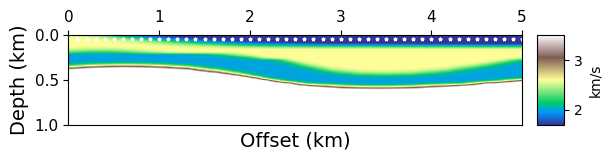

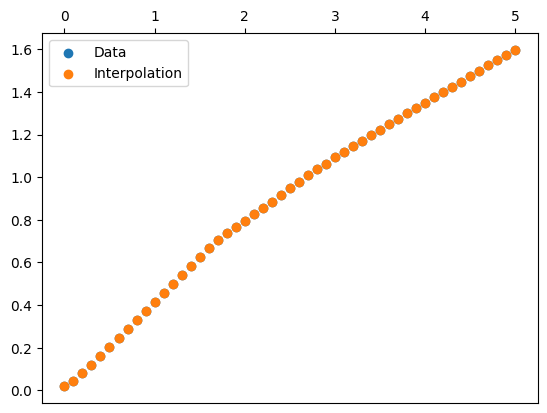

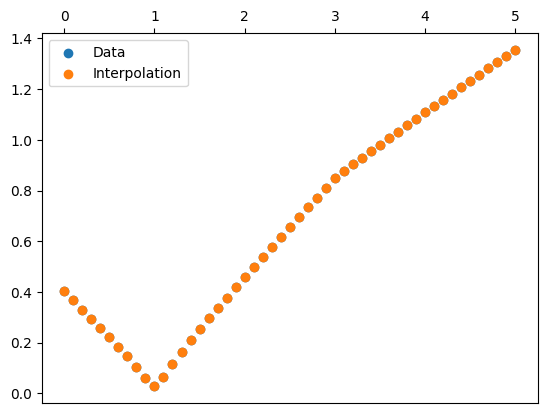

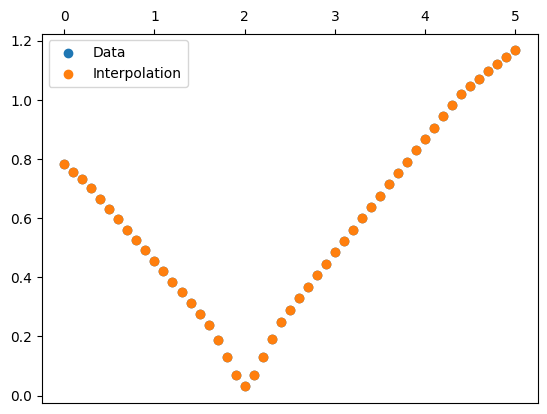

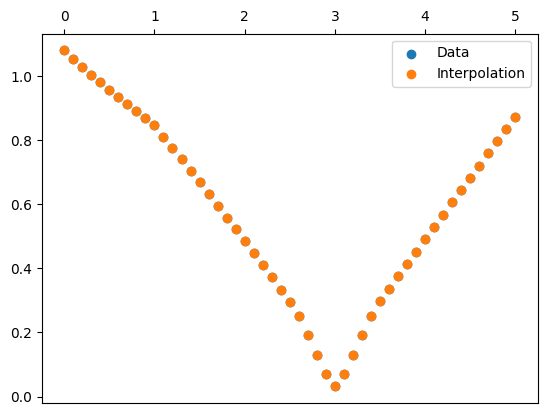

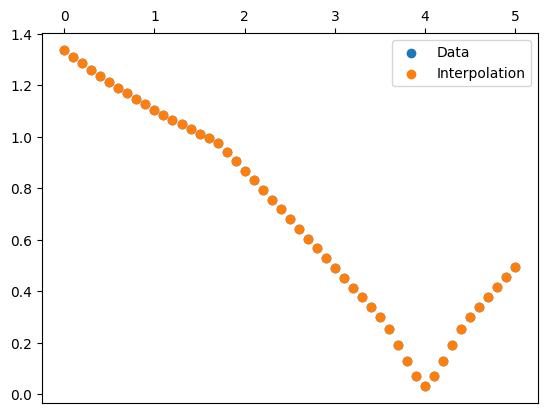

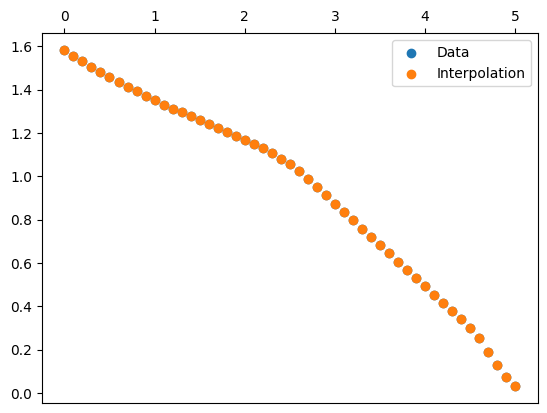

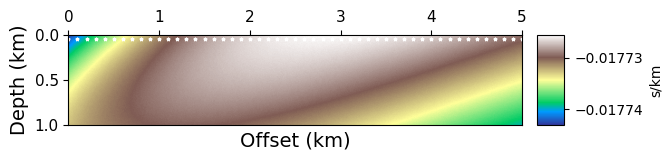

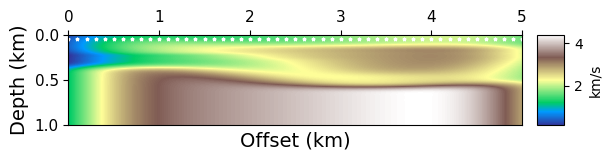

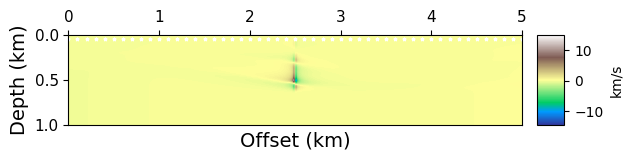

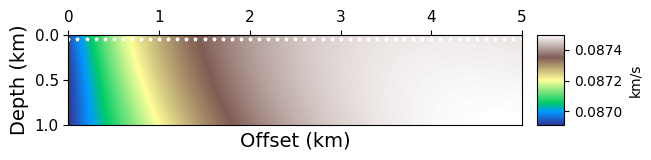

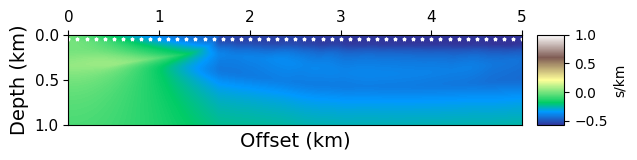

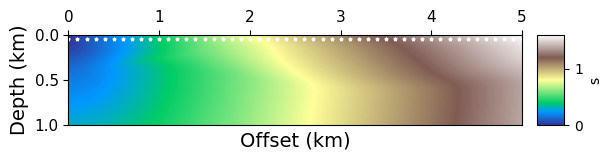

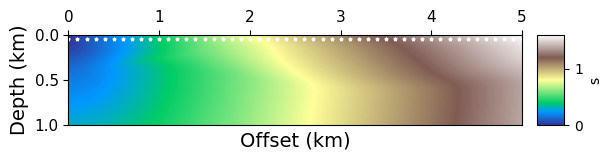

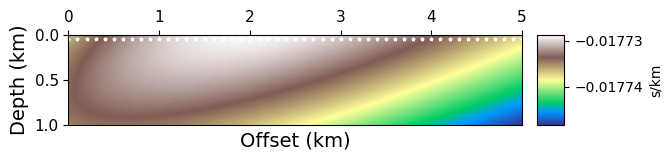

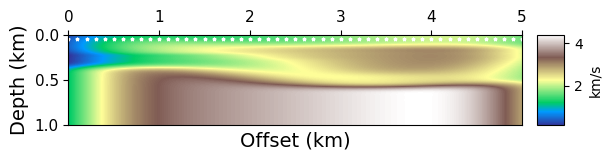

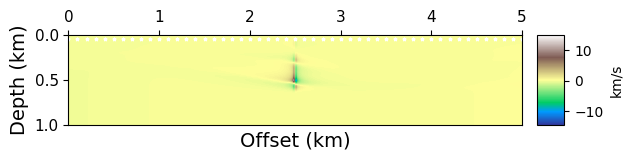

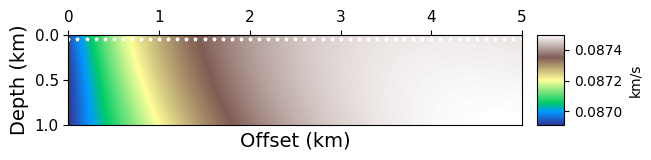

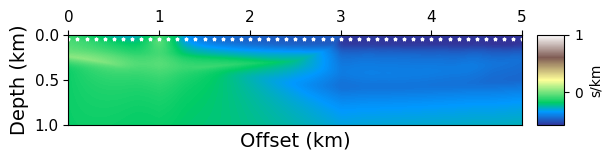

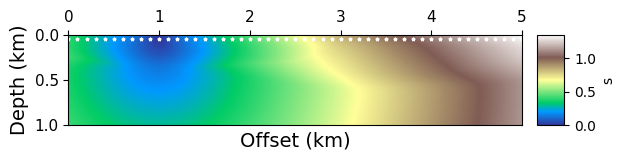

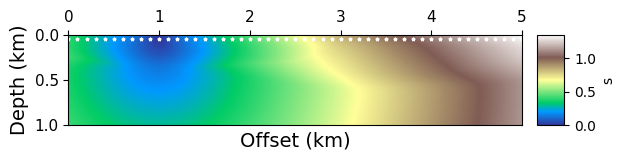

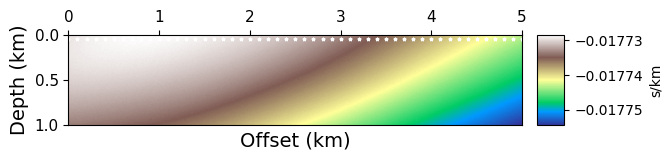

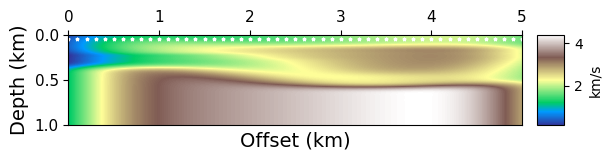

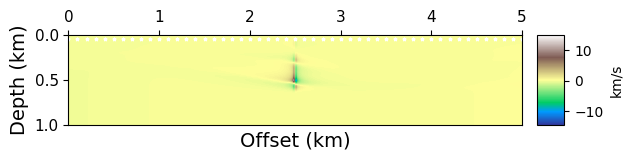

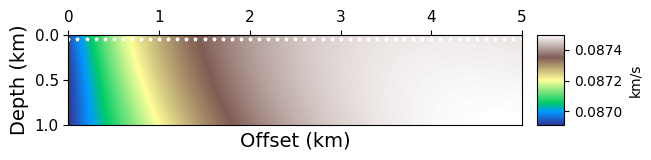

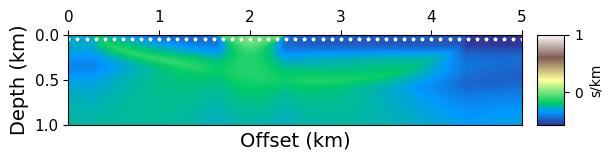

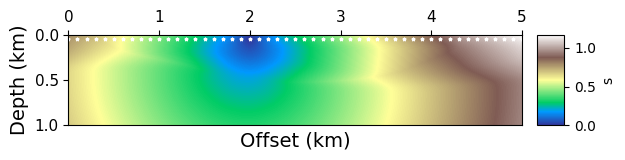

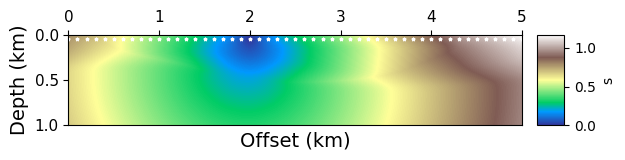

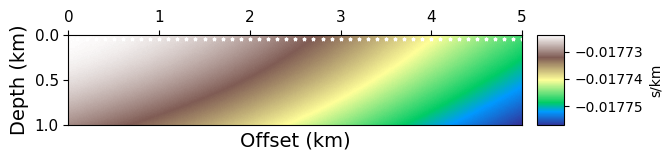

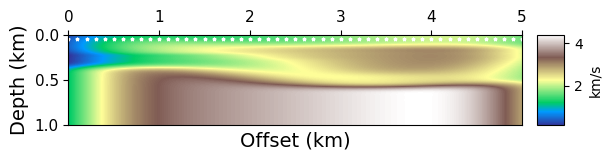

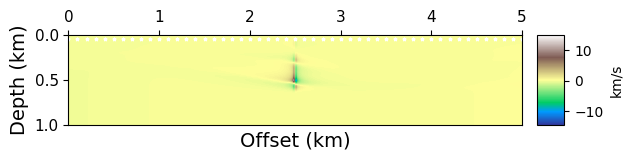

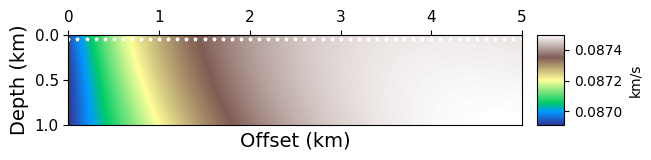

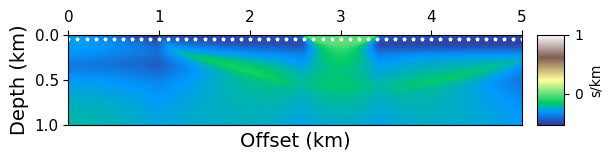

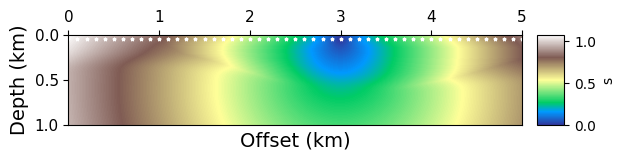

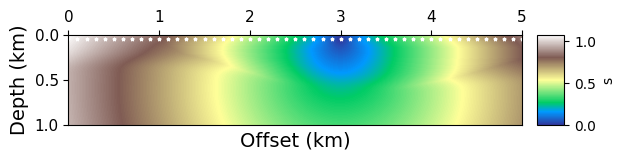

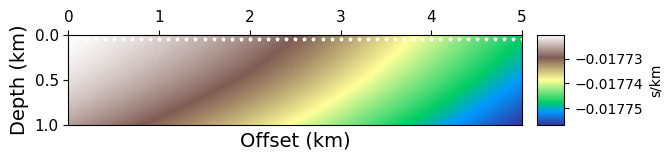

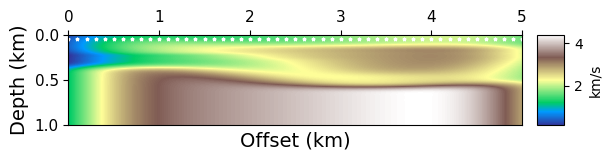

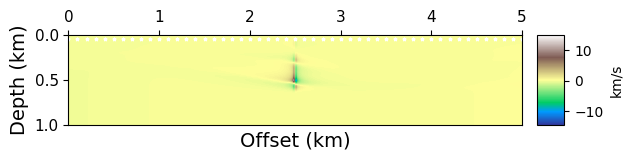

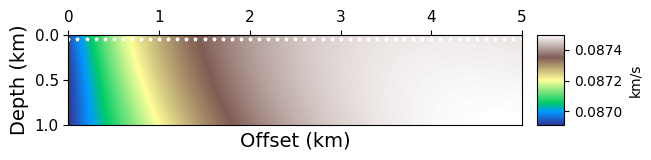

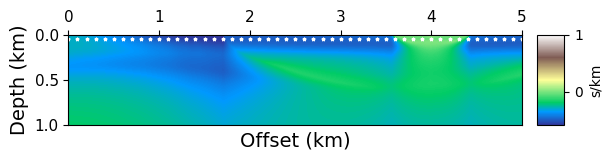

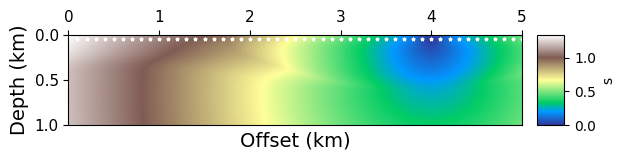

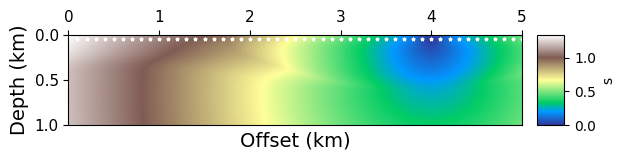

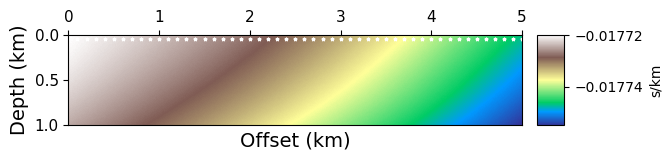

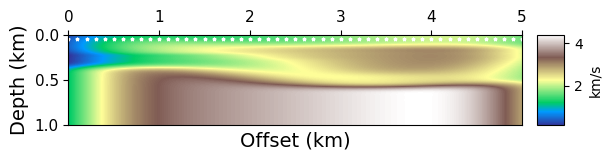

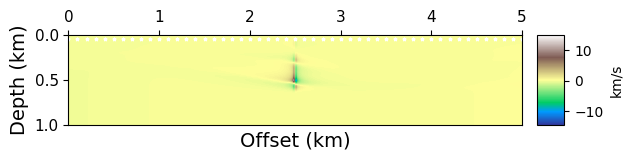

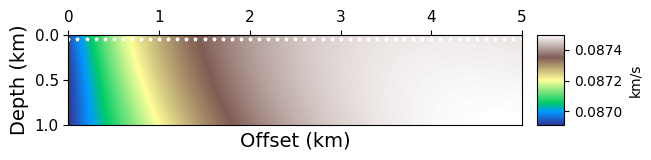

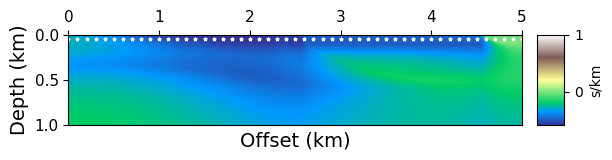

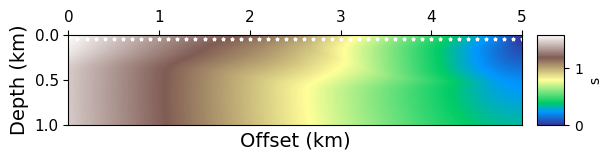

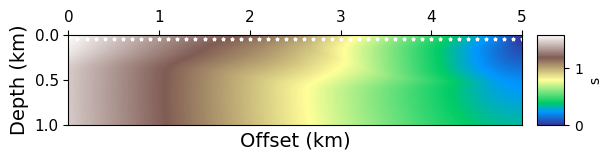

In [3]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Medium
data_type = args.data_type
deltar = args.rec_spacing
deltas = args.sou_spacing

# Computational model parameters
zmin = -0.1 if args.field_synthetic=='y' else 0; zmax = args.max_depth; deltaz = args.vertical_spacing;
xmin = 0.; xmax = args.max_offset; deltax = args.lateral_spacing;

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

# Number of training points
num_tr_pts = 4000 #int(args.num_points * nz * nx)

# Setup acquisition
zeve, xeve, zsta, xsta, ztop, xtop, id_rec_x, id_rec_z, id_sou_x, id_sou_z = setup_acquisition(xmin, xmax, zmin, zmax, x, z, deltar, deltas, dict_args)

sz = z[id_sou_z]
sx = x[id_sou_x]

Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')

SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX

# Velocity model
vel, VEL = velocity_model(xmin, xmax, zmin, zmax, x, z, sx, sz, dict_args)

print(np.nanmax(VEL), len(id_rec_z), len(id_rec_x), len(id_sou_z), len(id_sou_x))
plot_section(VEL[:,:,0], 'v_true.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z])

if args.depth_shift=='y':
    zmin, zmax, z, sz, Z, SZ = zmin+5, zmax+5, z+5, sz+5, Z+5, SZ+5

X_star = [Z.reshape(-1,1), X.reshape(-1,1), SX.reshape(-1,1)] # Grid points for prediction 

# Numerical traveltime
T_data = numerical_traveltime(vel, len(x), len(z), len(id_sou_x), xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z)

# Plots
if args.model_type=='checkerboard':
    plot_section((6 + 6.5217391304347826*Z[:,:,0])/args.scale_factor, "v_back.png", 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])
    plot_section(velpert[:,:,0]/args.scale_factor, "v_pert.png", 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

# Interpolation

Td_nn = np.zeros_like(T_data)
taudx_nn = np.zeros_like(T_data)

Ti_data = np.zeros((len(x[id_rec_x])*len(id_sou_x)))
xri = np.tile(x[id_rec_x], len(id_sou_x))
zri = np.tile(z[id_rec_z], len(id_sou_z))
xsi = np.repeat(x[id_sou_x], len(id_rec_x))
zsi = np.repeat(z[id_sou_z], len(id_rec_z))

for i in range(len(id_sou_x)):
    Ti_data[i*len(x[id_rec_x]):(i+1)*len(x[id_rec_x])] = T_data[id_rec_z,id_rec_x,i]

rand_idx = np.random.permutation(np.arange(len(Ti_data)))

X_ori = np.vstack((xri, zri, xsi, zsi)).T
y_ori = Ti_data

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

if data_type=='nn':
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(4, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(5e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn = np.zeros_like(T_data)
    
    if args.field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx)), np.tile(z[args.zid_receiver]*np.ones_like(x), len(sz)), 
                 np.repeat(x[id_sou_x], len(x)), 
                 np.repeat(z[id_sou_z], len(x))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou_x)):
        Td_nn[:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join(wandb_dir, "data_loss.png"), format='png', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, wandb_dir+'/saved_data_model')

# Analytical solution for the known traveltime part
if args.depth_shift=='y':
    vs = args.initial_velocity #VEL[np.round((SZ-5)/deltaz).astype(int),np.round(SX/deltax).astype(int),0]
else:
    vs = VEL[np.round(SZ/deltaz).astype(int),np.round(SX/deltax).astype(int),0]

T0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vs;
px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

if args.field_synthetic=='y':
    xf = np.arange(xmin,xmax+0.1*deltax,0.1*deltax)
    zf = np.arange(zmin,zmax+0.1*deltaz,0.1*deltaz)
    T_topo = np.zeros((len(zf), len(xf), len(id_sou_x)))
    for i in range(len(id_sou_x)):
        f = interpolate.interp2d(x, z, T_data[:,:,i], kind='cubic')
        T_topo[:,:,i] = f(xf, zf)
    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    taud_topo = np.divide(T_data, T0, where=T0!=0)[id_top_z, id_top_x, :]
    T_topo = T_data[id_top_z, id_top_x, :]

    taud_topo = np.repeat(taud_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)
    T_topo = np.repeat(T_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)

Td_hc = np.zeros_like(T0)
T0_hc = np.zeros_like(T0)
taud_hc = np.zeros_like(T0)
taudx_hc = np.zeros_like(T0)

for i in range(len(id_sou_x)):
    T0_hc[:,:,i] = np.tile(T0[0,:,i], nz).reshape(nz,nx)

    # Numerical
    if data_type=='full':
        Td_hc[:,:,i] = np.tile(T_data[0,:,i], nz).reshape(nz,nx)

    # NN-based interpolation
    elif data_type=='nn':
        Td_hc[:,:,i] = Td_nn[:,:,i].reshape(nz,nx)

    if args.factorization_type=='multiplicative':   
        taud_hc[:,:,i] = np.divide(Td_hc[:,:,i], T0_hc[:,:,i], out=np.ones_like(T0_hc[:,:,i]),
                                   where=T0_hc[:,:,i]!=0)
    else:
        taud_hc[:,:,i] = Td_hc[:,:,i] - T0_hc[:,:,i]

    # Numerical
    if data_type=='full':
        taudx_hc[:,:,i] = np.gradient(taud_hc.reshape(nz,nx,len(id_sou_x))[:,:,i], deltax, axis=1)

    # NN-based interpolation
    elif data_type=='nn':
        taudx_hc[:,:,i] = np.gradient(taud_hc.reshape(nz,nx,len(id_sou_x))[:,:,i], deltax, axis=1)

if args.field_synthetic=='y':

    NAN = np.ones_like(X)
    for i in range(z.shape[0]):
        for j in range(x.shape[0]):
            if z[i] < Z[id_top_z, id_top_x, 0][j]:
                NAN[i,j,:] = float("Nan")
                
# Evaluating initial velocity model and traveltimes
id_well_x = args.xid_well
dv_dz = 0.2
v0 = 1 + dv_dz*Z
# v_well = vel[:,id_well_x]
v_well = scipy.ndimage.filters.gaussian_filter(vel, [0.001,55], mode='constant')

nuw = np.ones_like(taud_hc)
for i in range(len(x)):
    if args.well_depth >= len(z):
        # nuw[:,i,:] = np.repeat(v_well/v0[:,i,0], len(id_sou_x)).reshape(nz, len(id_sou_x))
        nuw[:,i,:] = np.repeat(v_well[:,i]/v0[:,i,0], len(id_sou_x)).reshape(nz, len(id_sou_x))
    else:
        nuw[:args.well_depth,i,:] = np.repeat(v_well[:args.well_depth]/v0[:args.well_depth,i,0], len(id_sou_x)).reshape(len(z[:args.well_depth]), len(id_sou_x))
          
# Interpolation check            
plot_int = len(id_sou_x)//5 if len(id_sou_x)>=5 else 1
for i in range(0, len(id_sou_x), plot_int):
    plt.figure()
    plt.scatter(x[id_rec_x], T_data[id_rec_z,id_rec_x,i], label='Data')
    plt.scatter(x[id_rec_x], Td_hc[id_rec_z,id_rec_x,i], label='Interpolated')
    plt.legend(['Data', 'Interpolation'])
    plt.savefig(os.path.join(wandb_dir, "interpolation.png"), format='png', bbox_inches="tight")

# Model declaration
import time
start_time = time.time()

TOLX = 1e-6
TOLZ = 1e-6

sids = np.array([]).astype(int)

for sxi in sx:
    # print(sxi)
    sid,_ = np.where(np.logical_and(np.logical_and(np.abs(X_star[0]-sz)<TOLZ , np.abs(X_star[1]-sxi)<TOLX), np.abs(X_star[2]-sxi)<TOLX))
    sids = np.append(sids,sid)  
isource = np.ones_like(X_star[0]).reshape(-1,).astype(bool)
isource[sids] = False

VEL = VEL.reshape(-1,1)
px0 = px0.reshape(-1,1)
pz0 = pz0.reshape(-1,1)
T0 = T0.reshape(-1,1)
T_data = T_data.reshape(-1,1)

taud = taud_hc.reshape(-1,1)
if args.factorization_type=='multiplicative':
    taud[~isource] = 1.   
taudx = taudx_hc.reshape(-1,1)

v0 = v0.reshape(-1,1)
nuw = nuw.reshape(-1,1)

v0ic = v0[~isource]
nuwic = nuw[~isource]

# xz, s, taud, taud_dz, t0, t0_dx, t0_dz in data_loader:

if args.exclude_well=='n':
    input_wsrc = [X, Z, SX, taud, taudx, T0, px0, pz0, v0, nuw, v0ic, nuwic]
    perm_id = np.random.permutation(X.size-sx.size)
else:
    # train_id = ((X<(x[args.xid_well]-5*deltax))|(X>(x[args.xid_well]+5*deltax)))
    train_id = (X!=x[args.xid_well])
    input_wwell = [X, Z, SX, taud, taudx, T0, px0, pz0, v0, nuw, v0ic, nuwic]
    # wwell_id = np.random.permutation(X.size-sx.size)
    input_wsrc = [X[train_id], Z[train_id], SX[train_id], taud.reshape(X.shape)[train_id], 
                  taudx.reshape(X.shape)[train_id], T0.reshape(X.shape)[train_id], 
                  px0.reshape(X.shape)[train_id], pz0.reshape(X.shape)[train_id], 
                  v0.reshape(X.shape)[train_id], nuw.reshape(X.shape)[train_id], 
                  v0ic, nuwic]
    perm_id = np.random.permutation(X[train_id].size-sx.size)
    isource = isource.reshape(X.shape)[train_id]

input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc[:-2]]
input_wosrc = input_wosrc + [v0ic, nuwic]

# network
lay = 'linear'
ini = args.initialization
bias, mean, std = args.initial_bias, args.initial_mean, args.initial_deviation
opttype = 'adam'
lr = args.learning_rate

# SciANN uses variance_scaling normal or Glorot (Xavier) normal for the weight initialization
# SciANN uses uniform for the bias initialization

torch.manual_seed(seed)
if args.residual_network=='n':
    tau_model = FullyConnectedNetwork(3, 1, [args.num_neurons]*args.num_layers, last_act=args.tau_act, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
else:
    tau_model = ResidualNetwork(3, 1, num_neurons=args.num_neurons, last_act=args.tau_act, num_layers=args.num_layers, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)

tau_model.to(device)

torch.manual_seed(seed)
if args.residual_network=='n':
    v_model = FullyConnectedNetwork(2, 1, [args.num_neurons]*args.num_layers, act=args.activation, last_act=None, lay=lay, last_multiplier=args.v_multiplier)
else:
    v_model = ResidualNetwork(2, 1, num_neurons=args.num_neurons, act=args.activation, last_act=None, num_layers=args.num_layers, lay=lay, last_multiplier=args.v_multiplier)

v_model.to(device)
v_model.apply(lambda m: init_weights(m, init_type=ini, bias=bias, mean=mean, std=std))

perc = args.num_points

if args.irregular_grid=='y':
    npoints = int(X.size * perc)
    ipermute = np.random.permutation(np.arange(X.size))[:npoints]
else:
    ipermute = None

# Compute traveltime with randomly initialized network
if args.exclude_well=='y':
    pde_loader, ic, _ = create_dataloaderwell([i.ravel() for i in input_wwell], sx, np.ones_like(sx)*sz.reshape(-1,), shuffle=False, fast_loader=True)
else:
    pde_loader, ic, _ = create_dataloaderwell([i.ravel() for i in input_wsrc], sx, np.ones_like(sx)*sz.reshape(-1,),
                                   shuffle=False, fast_loader=True, perm_id=ipermute)

if args.tau_function=='exp':
    # rec_op = (1-np.exp(Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver])**1e-5)
    rec_op = (1-np.exp((Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver])**args.exp_factor))
else:
    rec_op = (Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver])

if args.factorization_type=='multiplicative':
    tau_true = np.divide(
        T_data.reshape(nz,nx,len(id_sou_x)), 
        T0.reshape(nz,nx,len(id_sou_x)), 
        out=np.ones_like(T0.reshape(nz,nx,len(id_sou_x))), 
        where=T0.reshape(nz,nx,len(id_sou_x))!=0
    )
    tau_true = tau_true - taud.reshape(nz,nx,len(id_sou_x))
    tau_true = np.divide(
        tau_true, 
        rec_op, 
        out=np.ones_like(Z.reshape(nz,nx,len(id_sou_x))), 
        where=Z.reshape(nz,nx,len(id_sou_x))!=0
    )
    T_true = (rec_op*tau_true + taud.reshape(nz,nx,len(id_sou_x)))*T0.reshape(nz,nx,len(id_sou_x))
else:
    tau_true = T_data.reshape(nz,nx,len(id_sou_x)) - T0.reshape(nz,nx,len(id_sou_x)) - taud.reshape(nz,nx,len(id_sou_x))
    tau_true = np.divide(
        tau_true, 
        rec_op, 
        out=np.ones_like(Z.reshape(nz,nx,len(id_sou_x))), 
        where=Z.reshape(nz,nx,len(id_sou_x))!=0
    )
    T_true = rec_op*tau_true + taud.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))

# Compute v
if args.with_well=='y':
    v_init = evaluate_velocity(v_model, pde_loader, torch.from_numpy(x[[dict_args['xid_well']]]).to(device), dict_args)
    nu_init = evaluate_nu(v_model, pde_loader)
else:
    v_init = evaluate_nu(v_model, pde_loader)
tau_init = evaluate_tau(tau_model, pde_loader)

elapsed = time.time() - start_time
print('Loading time: %.2f minutes' %(elapsed/60.))

# Optimizer
if opttype == 'adam':
    if args.dual_optimizer=='n':
        optimizer = torch.optim.Adam(list(tau_model.parameters()) + list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
    else:
        v_optimizer = torch.optim.Adam(list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
        tau_optimizer = torch.optim.Adam(list(tau_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
        
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()) + list(v_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
if args.dual_optimizer=='n':
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=args.num_epochs//8, verbose=True)
else:
    v_scheduler = ReduceLROnPlateau(v_optimizer, mode='min', factor=0.5, patience=args.num_epochs//8, verbose=True)
    tau_scheduler = ReduceLROnPlateau(tau_optimizer, mode='min', factor=0.5, patience=args.num_epochs//8, verbose=True)

# Sanity checks
nuw = nuw.reshape(nz,nx,-1)
v_init = v_init.reshape(nz,nx,-1)
v0 = v0.reshape(nz,nx,-1)
VEL = VEL.reshape(nz,nx,-1)

if args.v_function=='l2':
    well_op = ((X.reshape(nz,nx,-1)-x[args.xid_well])/(x-x[args.xid_well]).max())**2
elif args.v_function=='l1':
    well_op = 10*((X.reshape(nz,nx,-1)-x[args.xid_well])/(x-x[args.xid_well]).max())
elif args.v_function=='exp':
    well_op = 10*(1-np.exp((X - x[args.xid_well])))
elif args.v_function=='try':
    well_op = 1

nu_true = np.divide(
    VEL-nuw*v0, 
    # ((X.reshape(nz,nx,-1)-x[args.xid_well])/(np.max(x-x[args.xid_well])))**2, 
    well_op, 
    out=np.zeros_like(T0.reshape(nz,nx,len(id_sou_x))), 
    where=well_op!=0
)
v_true = well_op*nu_true + nuw*v0

for i in range(0, len(id_sou_x), len(id_sou_x)//5):
    plot_section(torch_to_numpy(tau_init.reshape(Z.shape)[:,:,i], nx, nz, -1), "tau_init_"+str(i)+".png", 's/km',
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    plot_section(torch_to_numpy(v_init.reshape(Z.shape)[:,:,i], nx, nz, -1), "v_init_"+str(i)+".png",
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    plot_section(nu_true.reshape(Z.shape)[:,:,i], "nu_true_"+str(i)+".png",
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])   
    plot_section(torch_to_numpy(nu_init.reshape(Z.shape)[:,:,i], nx, nz, -1), "nu_init_"+str(i)+".png",
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])   
    plot_section(tau_true[:,:,i], "tau_true_"+str(i)+".png", 's/km',
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    plot_section(T_true[:,:,i], "T_true_"+str(i)+".png", 's',
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])    
    plot_section(T_data.reshape(nz,nx,-1)[:,:,i], "T_data_"+str(i)+".png", 's',
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    
# Gradient checks
if data_type!='full':
    if args.field_synthetic=='y':
        for i in range(0, len(id_sou_x), plot_int):
            plot_horizontal(T_data.reshape(X.shape)[id_top_z,id_top_x,i], Td_nn[id_top_z,id_top_x,i], 
                            x*args.plotting_factor,'Interpolation Comparison','T (s)',
                            'T_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
            plot_horizontal(smooth(np.gradient(T_data.reshape(X.shape)[id_top_z,id_top_x,i]),2,'blackman'), 
                            np.gradient(Td_nn[id_top_z,id_top_x,i]), 
                            x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
                            'Tdx_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
    else:
        for i in range(0, len(id_sou_x), plot_int):
            plot_horizontal(T_data.reshape(X.shape)[0,:,i], Td_nn[0,:,i], 
                            x*args.plotting_factor,'Interpolation Comparison','T (s)',
                            'T_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)
            plot_horizontal(smooth(np.gradient(T_data.reshape(X.shape)[0,:,i]),2,'blackman'), np.gradient(Td_nn[0,:,i]), 
                            x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
                            'Tdx_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z)

/tmp/ipykernel_5577/1608667994.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  VW = scipy.ndimage.filters.gaussian_filter(vel, [0.001,55], mode='constant')


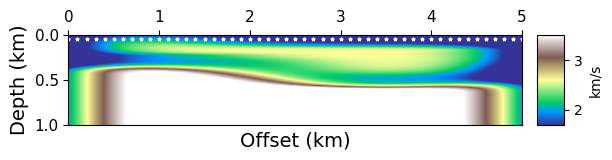

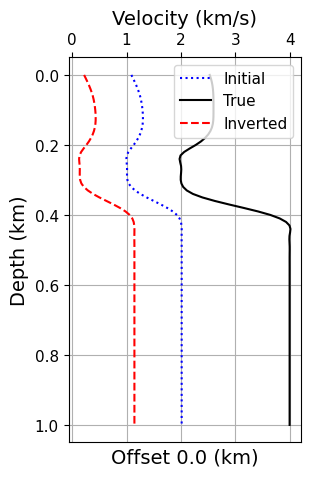

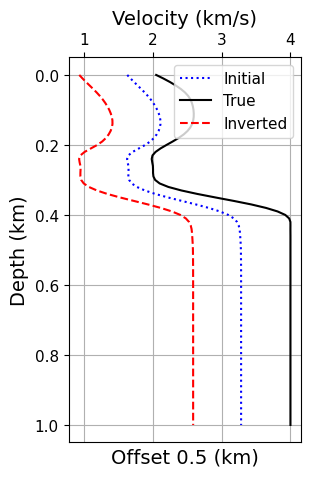

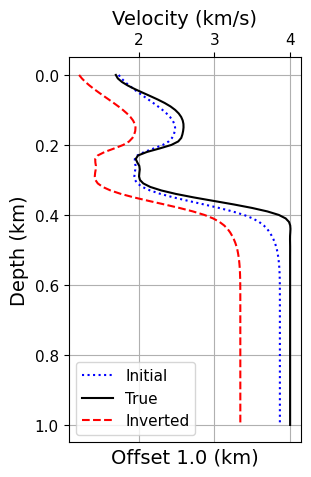

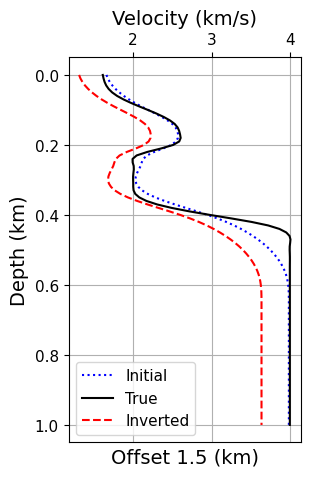

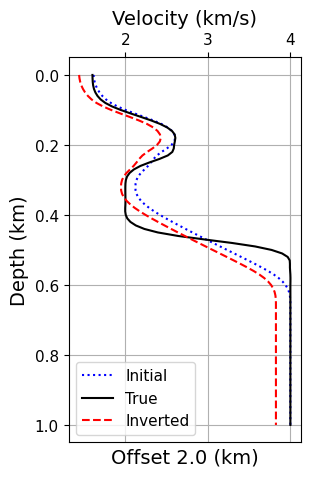

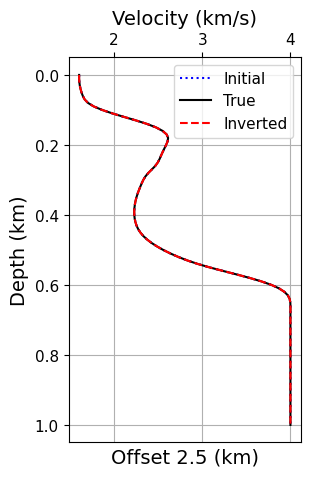

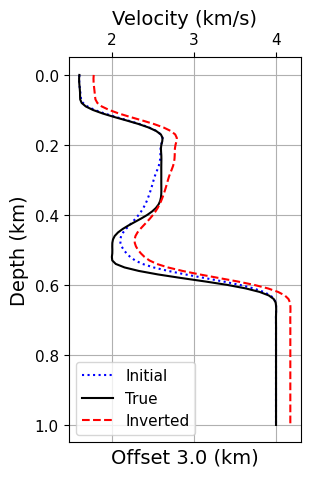

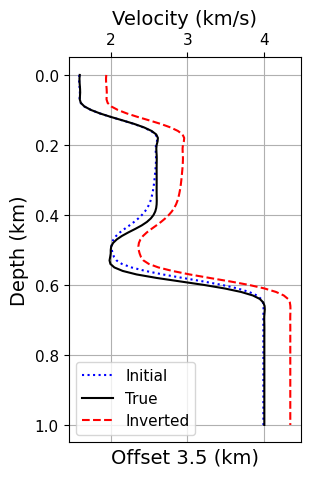

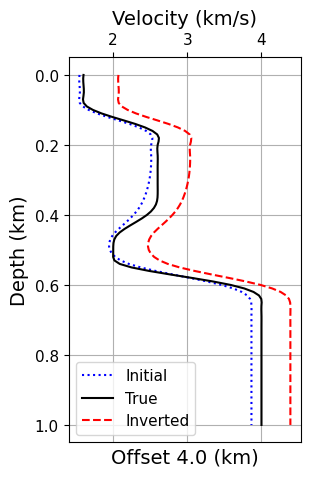

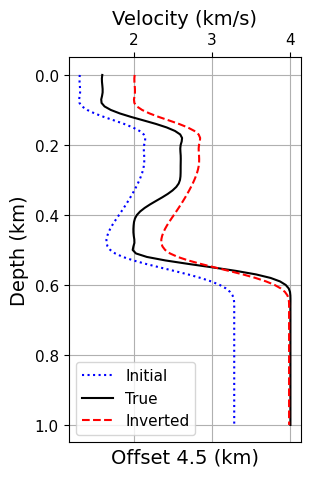

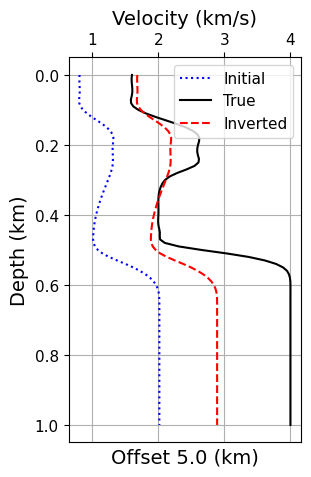

In [4]:
VW = scipy.ndimage.filters.gaussian_filter(vel, [0.001,55], mode='constant')

plot_section(VW, "v_smooth_"+str(i)+".png",
             save_dir=wandb_dir, aspect='equal', 
             vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5,
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],cmap='terrain')

for i in range(0, len(x), len(x)//10):
    plot_trace(VW, 
               v_true[:,:,0], 
               v_init.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))[:,:,0], 
               i, x, z, "v_comp_"+str(i)+".png")

## Distance function

In [ ]:
args.v_function='exp'

if args.v_function=='l2':
    well_op = ((X.reshape(nz,nx,-1)-x[args.xid_well])/(x-x[args.xid_well]).max())**2
elif args.v_function=='l1':
    well_op = 10*((X.reshape(nz,nx,-1)-x[args.xid_well])/(x-x[args.xid_well]).max())
elif args.v_function=='exp':
    well_op = 10*(1-np.exp((X - x[args.xid_well])))
elif args.v_function=='try':
    well_op = 1

nu_true = np.divide(
    v0-nuw*v0, 
    # VEL-nuw*v0, 
    # ((X.reshape(nz,nx,-1)-x[args.xid_well])/(np.max(x-x[args.xid_well])))**2, 
    well_op, 
    out=np.zeros_like(T0.reshape(nz,nx,len(id_sou_x))), 
    where=well_op!=0
)
v_true = well_op*nu_true + nuw*v0

# v_true = well_op*smooth(nu_true[50,:,0],100bn,'blackman') + nuw*v0

for i in range(1):
    plot_section(nu_true.reshape(Z.shape)[:,:,i], None,
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])

In [ ]:
plt.figure()
plt.plot(smooth(nu_true[:,0,0],1,'blackman'))
plt.plot(nu_true[:,0,0])

plt.figure()
plt.plot((well_op[:,0,0]*nu_true[:,0,0] + nuw[:,0,0]*v0[:,0,0]))
plt.plot((well_op[:,0,0]*smooth(nu_true[:,0,0],2,'blackman') + nuw[:,0,0]*v0[:,0,0]))

In [ ]:
well_op.shape

In [ ]:
OFF=1
np.max(nu_true[:,args.xid_well+OFF,:]),np.min(nu_true[:,args.xid_well+OFF,:])

### Visualize 3D model

In [ ]:
tmp_idsx = [np.where(x==X[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))]
tmp_idsy = [np.where(y==Y[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))]
tmp_idsz = [np.where(z==Z[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))]

print([np.unique(np.isnan(i)) for i in input_wosrc])

for i in range(len(id_sou)):
    input_item = taudy.reshape(X.shape)
    print("Shot number #"+str(i+1)+" "+str(np.unique(input_item[0,:,:,i]==input_item[-1,:,:,i])))
 
for i in range(len(id_sou)):
    temp = np.copy(T_data3d.reshape(X.shape))
    print(temp[tmp_idsz[i], tmp_idsy[i], tmp_idsx[i], i])

for i in range(0,len(id_sou),len(id_sou)//3):
    # ZX plane after
    print(i,x[np.where(x==X[:,:,:,0].reshape(-1)[id_sou[i]])[0][0]])
    plot_section(Td_hc.reshape(X.shape)[:,np.where(y==Y[:,:,:,i].reshape(-1)[id_sou[i]])[0][0],:,i], 'T_data3d_zx.png', save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

    # XY plane
    plot_section(Td_hc.reshape(X.shape)[args.zid_source,:,:,i], 'T_data3d_xy.png', save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
                 sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Y[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Y[:,:,:,i].reshape(-1)[id_rec])

    # ZY plane
    plot_section(Td_hc.reshape(X.shape)[:,:,np.where(x==X[:,:,:,i].reshape(-1)[id_sou[i]])[0][0],i], 'T_data3d_zy.png', save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=Y[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

## Training and Inference

In [ ]:
plt.imshow(np.fromfile('../data/seam_arid', np.float32).reshape(400,400,600)[:,:,25]/1000)
plt.colorbar()

In [ ]:
plt.plot(np.fromfile('../data/seam_arid', np.float32).reshape(400,400,600)[250,250,25:325]/1000)

plt.figure()
plt.imshow(np.fromfile('../data/seam_arid', np.float32).reshape(400,400,600)[90,:,25:325]/1000)
plt.colorbar()

In [5]:
# Training
import time
start_time = time.time()

if args.field_synthetic=='y':
    loss_history = \
        training_loop(
            input_wonan, sx, np.ones_like(sx)*sz.reshape(-1,),
            tau_model, v_model, v_optimizer, tau_optimizer, args.num_epochs, torch.from_numpy(x[[dict_args['xid_well']]]).to(device), dict_args,
            batch_size=Z.size//200, device=device, v_scheduler=v_scheduler, tau_scheduler=tau_scheduler,
            fast_loader=True,wandb=dict_args['use_wandb']
    ) 
else:
    loss_history = \
        training_loop(
            input_wosrc, sx, np.ones_like(sx)*sz.reshape(-1,),
            tau_model, v_model, v_optimizer, tau_optimizer, args.num_epochs, torch.from_numpy(x[[dict_args['xid_well']]]).to(device), dict_args,
            batch_size=Z.size//200, device=device, v_scheduler=v_scheduler, tau_scheduler=tau_scheduler, 
            fast_loader=True,wandb=dict_args['use_wandb']
    )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);
plt.grid()
plt.savefig(os.path.join(wandb_dir, "loss.png"), format='png', bbox_inches="tight")

# Prediction
input_wsrc = [i.ravel() for i in input_wsrc]
if args.exclude_well=='y':
    pde_loader, ic, _ = create_dataloaderwell([i.ravel() for i in input_wwell], sx, np.ones_like(sx)*sz.reshape(-1,), shuffle=False, fast_loader=True)
else:
    pde_loader, ic, _ = create_dataloaderwell([i.ravel() for i in input_wsrc], sx, np.ones_like(sx)*sz.reshape(-1,),
                                   shuffle=False, fast_loader=True, perm_id=ipermute)

# Compute v
if args.with_well=='y':
    v_pred = evaluate_velocity(v_model, pde_loader, x[dict_args['xid_well']], dict_args)
    nu_pred = evaluate_nu(v_model, pde_loader)
else:
    v_pred = evaluate_nu(v_model, pde_loader)
    
tau_pred = evaluate_tau(tau_model, pde_loader)
tau_pred = tau_pred.detach().cpu().numpy().reshape(nz,nx,-1)

if args.tau_function=='exp':
    rec_op = (1-np.exp(Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver])**args.exp_factor)
else:
    rec_op = Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver]

if args.factorization_type=='multiplicative':
    t_pred = (taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred)*T0.reshape(nz,nx,len(id_sou_x))
else:
    t_pred = taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))

v_pred = v_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))
v_init = v_init.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))
v_true = VEL.reshape(Z.shape)

if args.rescale_plot=='y':
    earth_radi = args.plotting_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax

    if args.depth_shift=='y':
        zmin, zmax, deltaz = earth_radi*(zmin-5), earth_radi*(zmax-5), earth_radi*deltaz
    else:
        zmin, zmax, deltaz = earth_radi*(zmin-0), earth_radi*(zmax-0), earth_radi*deltaz

    # Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
    z = np.arange(zmin,zmax+deltaz,deltaz)
    x = np.arange(xmin,xmax+deltax,deltax)

    # Point-source locations
    sz = z[id_sou_z]
    sx = x[id_sou_x]

    Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')

    SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX

    t_pred, T_data, T0 = t_pred*args.plotting_factor, T_data*args.plotting_factor, T0*args.plotting_factor

plot_section(v_pred[:,:,0], "v_pred.png",vmin=np.nanmin(VEL), vmax=np.nanmax(VEL))

for i in range(0, len(id_sou_x), len(id_sou_x)//5):
    plot_section(torch_to_numpy(tau_init.reshape(Z.shape)[:,:,i], nx, nz, -1), "tau_init_"+str(i)+".png", 's/km')
    plot_section(tau_true[:,:,i], "tau_true_"+str(i)+".png", 's/km',vmin=np.nanmin(tau_true)+0.095, vmax=np.nanmax(tau_true)-0.395)
    plot_section(tau_pred.reshape(Z.shape)[:,:,i], "tau_pred_"+str(i)+".png", 's/km',vmin=np.nanmin(tau_true)+0.095, vmax=np.nanmax(tau_true)-0.395)
    # plot_contour(t_pred.reshape(nz,nx,len(id_sou_x)), T_data.reshape(nz,nx,len(id_sou_x)),T0.reshape(nz,nx,len(id_sou_x)),i,'contour_'+str(i)+'.png')
    plot_section(t_pred.reshape(nz,nx,len(id_sou_x))[:,:,i], 't_pred_'+str(i)+'.png', 's') 
    plot_section(v_pred.reshape(X.shape)[:,:,i],None,vmin=np.nanmin(VEL), vmax=np.nanmax(VEL))
    plot_section(v_true[:,:,i], None,vmin=np.nanmin(VEL), vmax=np.nanmax(VEL))

for i in range(0, len(x), len(x)//10):
    plot_trace(v_init[:,:,0], v_true[:,:,0], v_pred[:,:,0], i, x, z, "v_trace_"+str(i)+".png")
    
# Save model
torch.save({
        'tau_model_state_dict': tau_model.state_dict(),
        'v_model_state_dict': v_model.state_dict(),
        'tau_optimizer_state_dict': tau_optimizer.state_dict(),
        'v_optimizer_state_dict': v_optimizer.state_dict(),
        'loss': loss_history
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
tau_optimizer.load_state_dict(checkpoint['tau_optimizer_state_dict'])
v_optimizer.load_state_dict(checkpoint['v_optimizer_state_dict'])

Number of points used per epoch:2575449
Epoch 0, Loss 0.0605955

Best loss: 0.060595517214387655

Saving best model for epoch: 1

Epoch 3, Loss 0.0054821
Epoch 6, Loss 0.0035867
Epoch 9, Loss 0.0035663
Epoch 12, Loss 0.0035641
Epoch 15, Loss 0.0035626
Epoch 18, Loss 0.0035601
Epoch 21, Loss 0.0033487
Epoch 24, Loss 0.0025848
Epoch 27, Loss 0.0022890
Epoch 30, Loss 0.0021635
Epoch 33, Loss 0.0020631
Epoch 36, Loss 0.0019877
Epoch 39, Loss 0.0019687
Epoch 42, Loss 0.0019264
Epoch 45, Loss 0.0018188
Epoch 48, Loss 0.0017631

Best loss: 0.001885529681458138

Saving best model for epoch: 51

Epoch 51, Loss 0.0017377
Epoch 54, Loss 0.0017132
Epoch 57, Loss 0.0016899
Epoch 60, Loss 0.0016629
Epoch 63, Loss 0.0016667
Epoch 66, Loss 0.0015131
Epoch 69, Loss 0.0015048
Epoch 72, Loss 0.0014778
Epoch 75, Loss 0.0012829
Epoch 78, Loss 0.0012691
Epoch 81, Loss 0.0011984
Epoch 84, Loss 0.0011671
Epoch 87, Loss 0.0011135
Epoch 90, Loss 0.0010539
Epoch 93, Loss 0.0009994
Epoch 96, Loss 0.0009684
Epoch 

KeyboardInterrupt: 

Number of points used per epoch:2529090
Epoch 0, Loss 0.0073336

Best loss: 0.00733363576475914

Saving best model for epoch: 1

Epoch 3, Loss 0.0052515
Epoch 6, Loss 0.0053083
Epoch 9, Loss 0.0011476
Epoch 12, Loss 0.0006839
Epoch 15, Loss 0.0005805
Epoch 18, Loss 0.0004590
Epoch 21, Loss 0.0003783

## Save models

In [6]:
# # Save model
# torch.save({
#         'tau_model_state_dict': tau_model.state_dict(),
#         'v_model_state_dict': v_model.state_dict(),
#         'tau_optimizer_state_dict': tau_optimizer.state_dict(),
#         'v_optimizer_state_dict': v_optimizer.state_dict()
# }, wandb_dir+'/saved_model')

# # To load
# checkpoint = torch.load(wandb_dir+'/saved_model')
# tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
# v_model.load_state_dict(checkpoint['v_model_state_dict'])
# tau_optimizer.load_state_dict(checkpoint['tau_optimizer_state_dict'])
# v_optimizer.load_state_dict(checkpoint['v_optimizer_state_dict'])

# To load
checkpoint = torch.load(wandb_dir+'/best_model.pth')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['nu_model_state_dict'])
tau_optimizer.load_state_dict(checkpoint['tau_optimizer_state_dict'])
v_optimizer.load_state_dict(checkpoint['nu_optimizer_state_dict'])

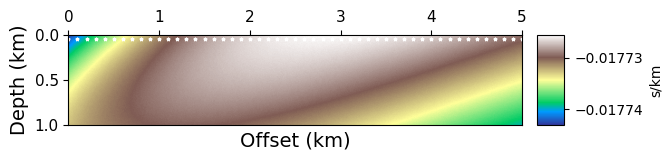

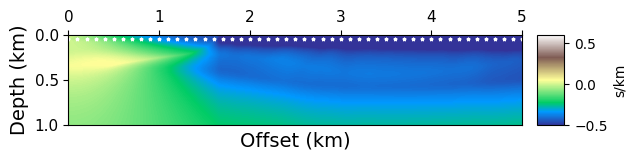

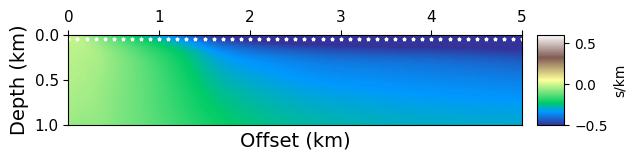

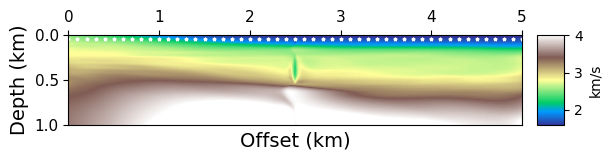

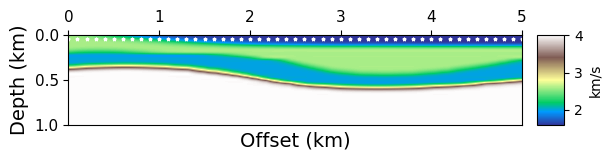

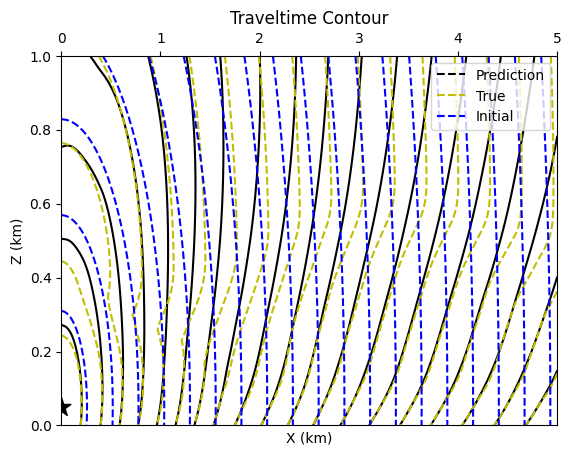

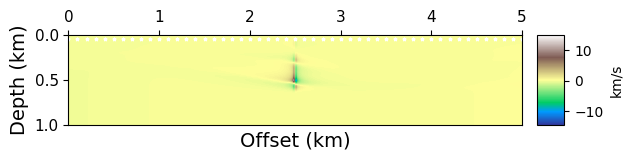

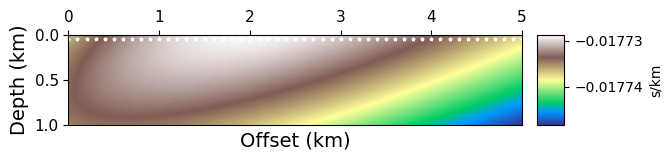

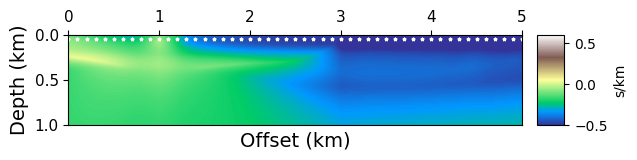

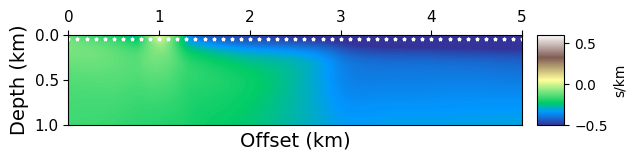

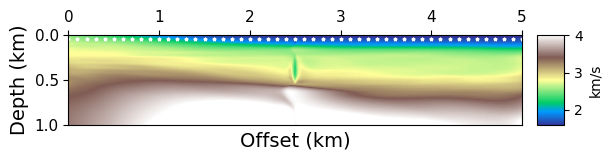

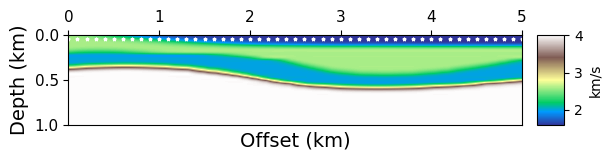

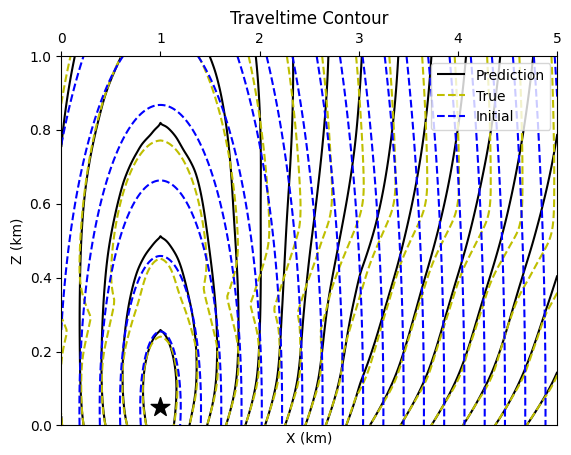

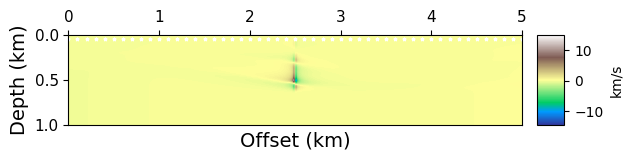

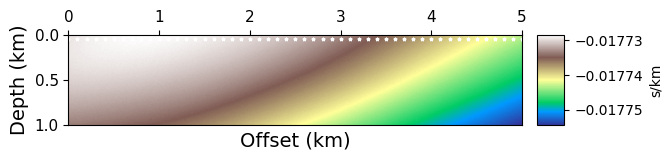

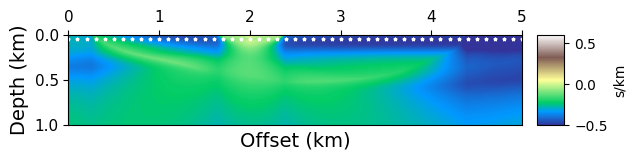

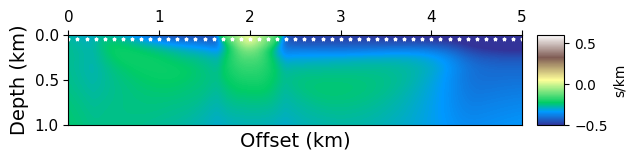

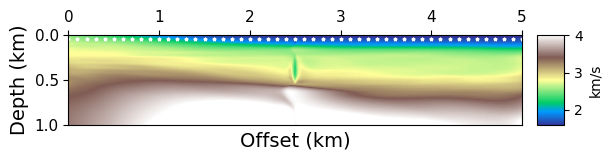

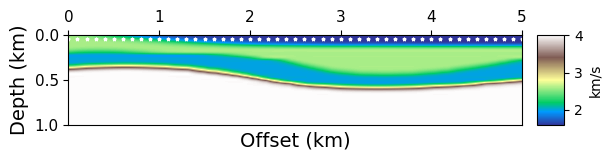

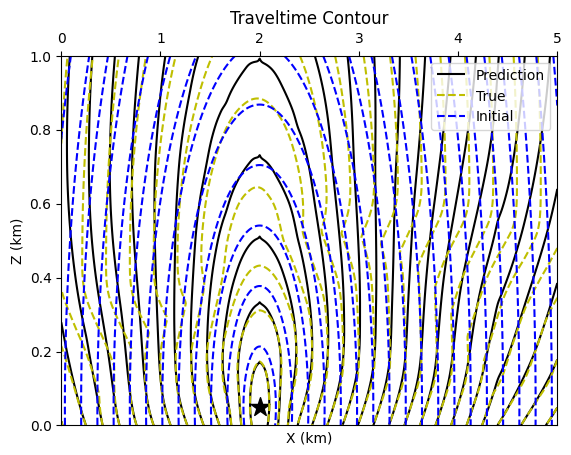

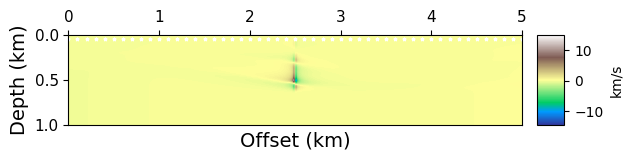

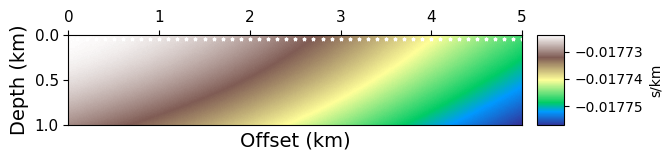

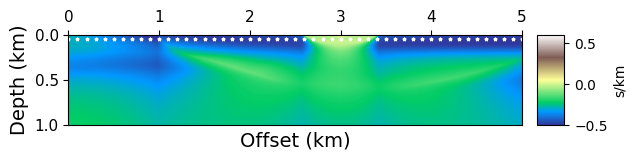

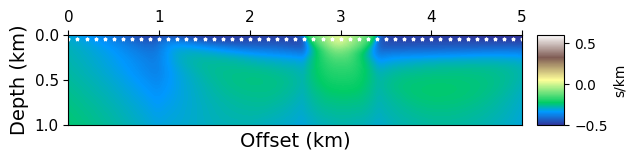

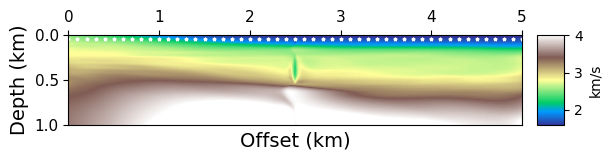

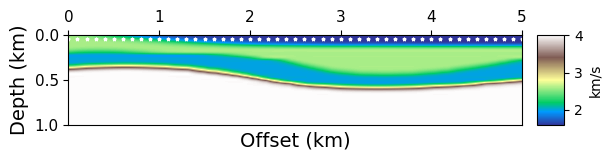

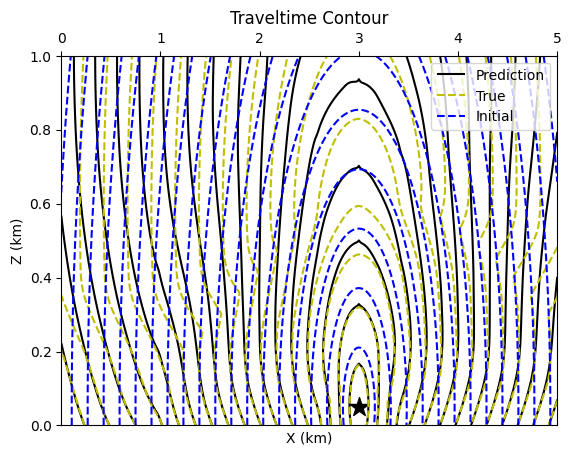

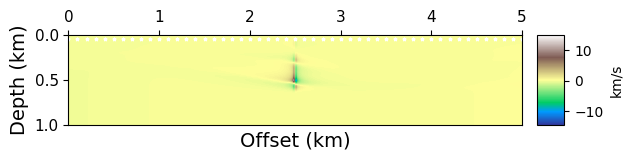

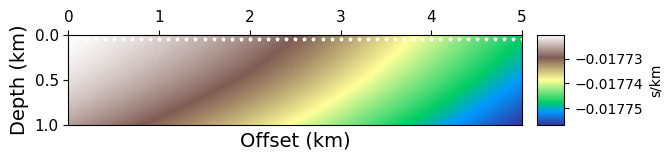

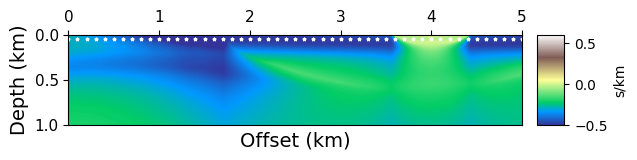

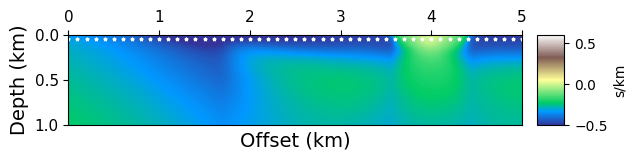

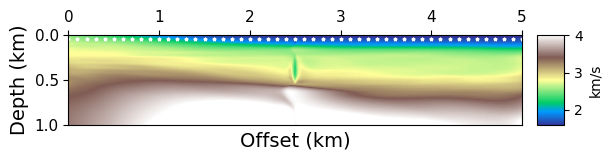

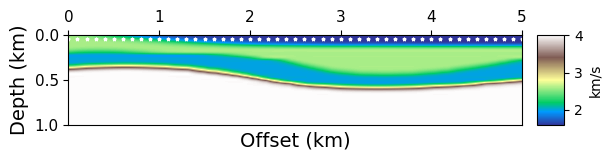

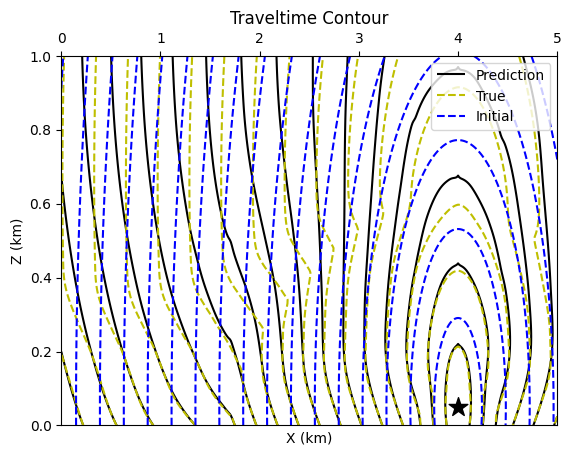

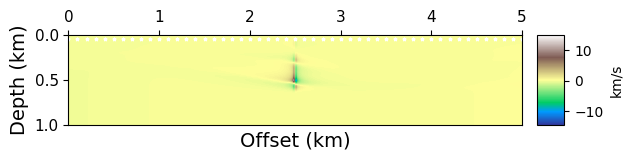

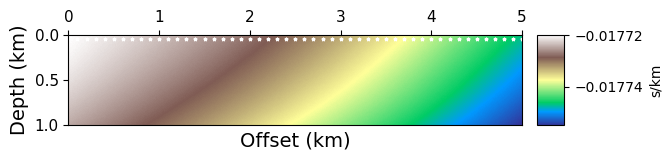

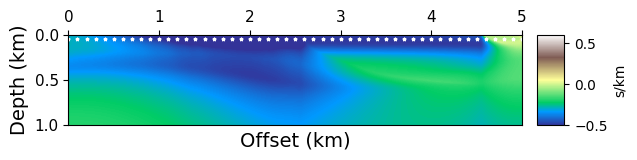

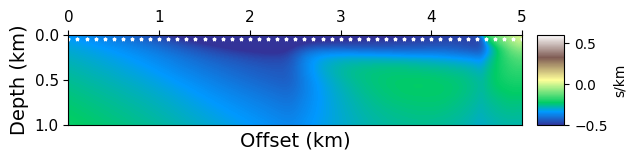

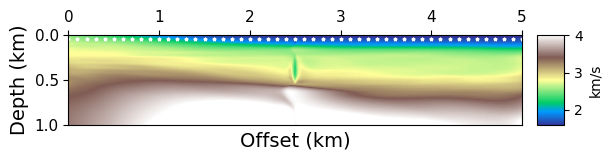

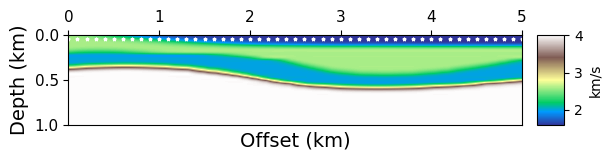

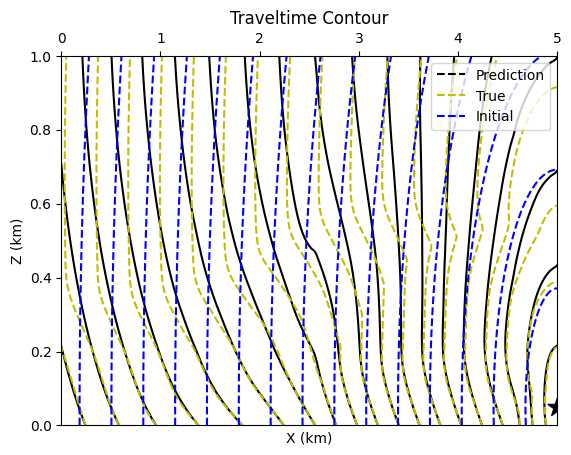

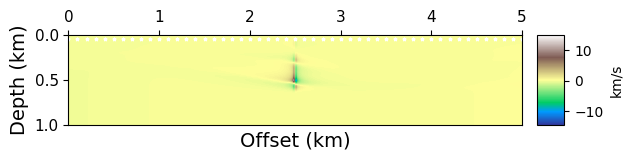

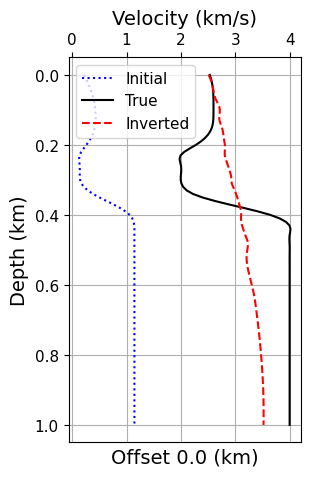

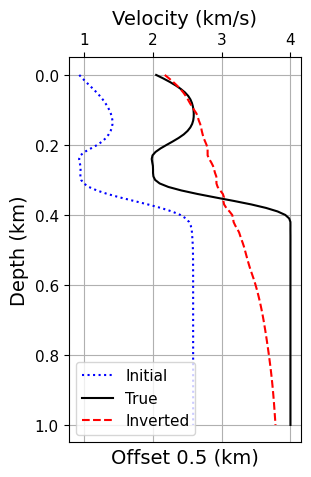

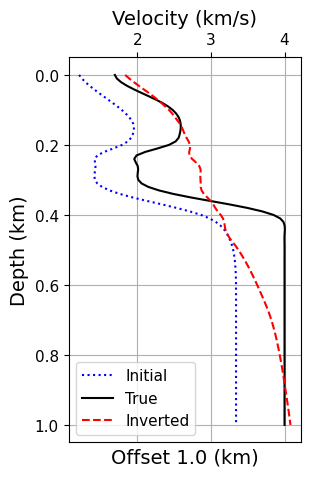

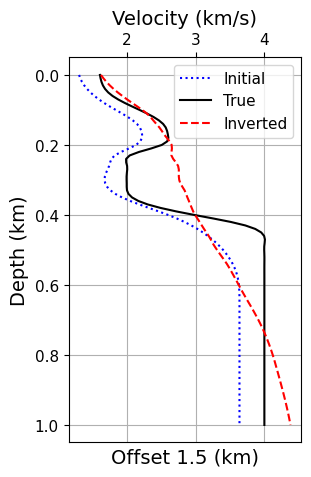

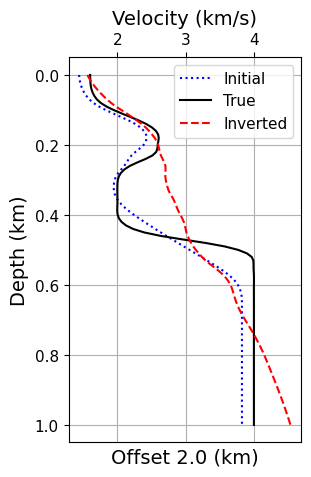

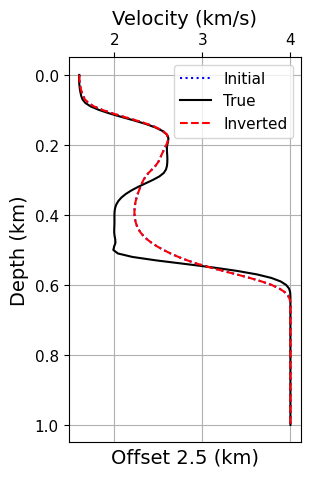

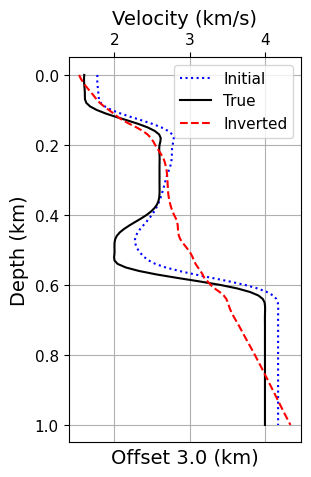

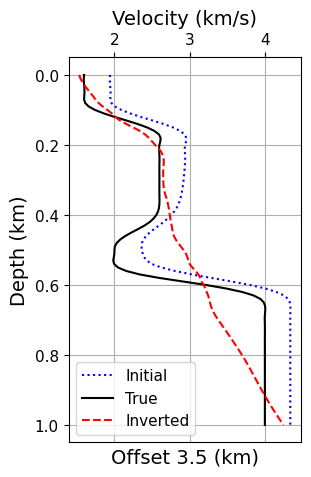

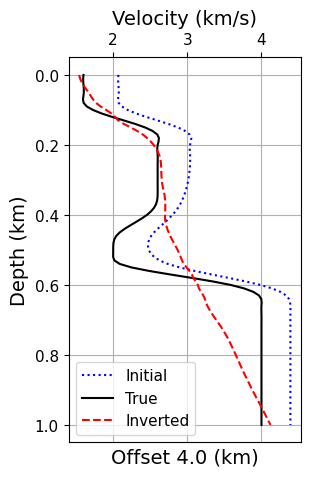

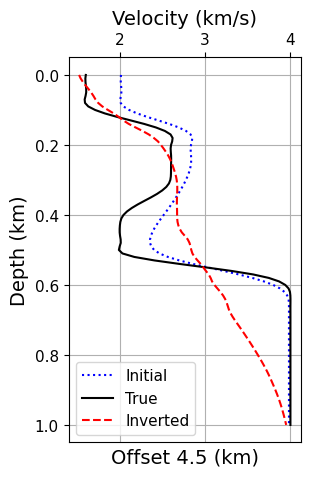

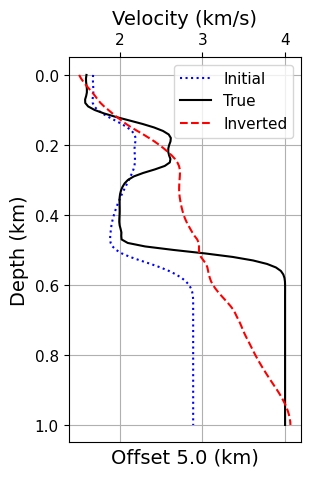

In [7]:
# Prediction
input_wsrc = [i.ravel() for i in input_wsrc]
if args.exclude_well=='y':
    pde_loader, ic, _ = create_dataloaderwell([i.ravel() for i in input_wwell], sx, np.ones_like(sx)*sz.reshape(-1,), shuffle=False, fast_loader=True)
else:
    pde_loader, ic, _ = create_dataloaderwell([i.ravel() for i in input_wsrc], sx, np.ones_like(sx)*sz.reshape(-1,),
                                   shuffle=False, fast_loader=True, perm_id=ipermute)

# Compute v
if args.with_well=='y':
    v_pred = evaluate_velocity(v_model, pde_loader, torch.from_numpy(x[[dict_args['xid_well']]]).to(device), dict_args)
    # nu_pred = evaluate_nu(v_model, pde_loader)
else:
    v_pred = evaluate_nu(v_model, pde_loader)
    
tau_pred = evaluate_tau(tau_model, pde_loader)
tau_pred = tau_pred.detach().cpu().numpy().reshape(nz,nx,-1)

if args.tau_function=='exp':
    rec_op = (1-np.exp(Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver])**args.exp_factor)
else:
    rec_op = Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver]

if args.factorization_type=='multiplicative':
    t_pred = (taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred)*T0.reshape(nz,nx,len(id_sou_x))
else:
    t_pred = taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))

v_pred = v_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))
# nu_pred = nu_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))
v_init = v_init.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x))
v_true = VEL.reshape(Z.shape)

if args.rescale_plot=='y':
    earth_radi = args.plotting_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax

    if args.depth_shift=='y':
        zmin, zmax, deltaz = earth_radi*(zmin-5), earth_radi*(zmax-5), earth_radi*deltaz
    else:
        zmin, zmax, deltaz = earth_radi*(zmin-0), earth_radi*(zmax-0), earth_radi*deltaz

    # Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
    z = np.arange(zmin,zmax+deltaz,deltaz)
    x = np.arange(xmin,xmax+deltax,deltax)

    # Point-source locations
    sz = z[id_sou_z]
    sx = x[id_sou_x]

    Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')

    SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX

    t_pred, T_data, T0 = t_pred*args.plotting_factor, T_data*args.plotting_factor, T0*args.plotting_factor

for i in range(0, len(id_sou_x), len(id_sou_x)//5):
    plot_section(torch_to_numpy(tau_init.reshape(Z.shape)[:,:,i], nx, nz, -1), "tau_init_"+str(i)+".png", 's/km', 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    plot_section(tau_true[:,:,i], "tau_true_"+str(i)+".png", 's/km',
                 vmin=np.nanmin(tau_true)+0.095, vmax=np.nanmax(tau_true)-0.395, 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    plot_section(tau_pred.reshape(Z.shape)[:,:,i], "tau_pred_"+str(i)+".png", 's/km',
                 vmin=np.nanmin(tau_true)+0.095, vmax=np.nanmax(tau_true)-0.395, 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    
    # plot_section(t_pred.reshape(nz,nx,len(id_sou_x))[:,:,i], 't_pred_'+str(i)+'.png', 's') 
    plot_section(v_pred.reshape(X.shape)[:,:,i],None,
                 vmin=np.nanmin(VEL), vmax=np.nanmax(VEL), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    plot_section(v_true[:,:,i], None,
                 vmin=np.nanmin(VEL), vmax=np.nanmax(VEL), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z])
    
    plot_contour(t_pred.reshape(nz,nx,len(id_sou_x)), 
                 T_data.reshape(nz,nx,len(id_sou_x)),
                 T0.reshape(nz,nx,len(id_sou_x)),
                 i, nx, nz, len(id_sou_x), sx, sz, x, z,'contour_'+str(i)+'.png')    

    plot_section(nu_true.reshape(Z.shape)[:,:,i], "nu_true_"+str(i)+".png",
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z]) 
    
    # plot_section(nu_pred.reshape(Z.shape)[:,:,i], "nu_pred_"+str(i)+".png",
    #          save_dir=wandb_dir, aspect='equal',
    #          xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
    #          sx=x[id_sou_x],sz=z[id_sou_z]) 
    
for i in range(0, len(x), len(x)//10):
    plot_trace(v_init[:,:,0], v_true[:,:,0], v_pred[:,:,0], i, x, z, "v_trace_"+str(i)+".png")

In [ ]:
OFF=0
np.max(nu_pred[:,:,:]),np.min(nu_pred[:,:,:])

In [ ]:
def plot_depth(data, fig_name, data_type='km/s', vmin=None, vmax=None, 
                 cmap='terrain', save_dir='./', aspect='equal', 
                 xmin=0, xmax=1, zmin=0, zmax=1, 
                 sx=None, sz=None, rx=None, rz=None):
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(data, extent=[xmin,xmax,zmax,zmin], cmap=cmap, 
                   aspect=aspect, vmin=vmin, vmax=vmax, interpolation='kaiser')
    
    if sx is not None:
        plt.scatter(sx, sz, 5, 'white', marker='*')
    
    if rx is not None:
        plt.scatter(rx, rz, 5, 'y', marker='v')
    
    plt.xlabel('Offset (km)', fontsize=14)
    plt.xticks(fontsize=11)
    plt.ylabel('Offset (km)', fontsize=14)
    plt.yticks(fontsize=11)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)
    
    cbar.set_label(data_type,size=10)
    
    if fig_name is not None:
        plt.savefig(os.path.join(save_dir, fig_name), 
                    format='png', bbox_inches="tight") 

In [ ]:
# XY plane
plot_depth(v_init.reshape(X.shape)[5,:,:,0], 'v_init_xy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou])

# XY plane
i=0
plot_depth(v_pred.reshape(X.shape)[5,:,:,i], 'v_pred_xy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Y[:,:,:,i].reshape(-1)[id_sou])

# XY plane
plot_depth(vel3d[5,:,:], 'v_true_xy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou])

In [ ]:
j=20

# ZX plane
plot_section(vel3d[:,:,j], 'v_true_zy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou])

# ZX plane
i=0
plot_section(v_pred.reshape(X.shape)[:,:,j,i], 'v_pred_zy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou])

# ZX plane
plot_section(v_init.reshape(X.shape)[:,:,j,0], 'v_init_zy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou])

## Playground

In [ ]:
# Interpolation

XX = torch.from_numpy(x+1).float()
YY = XX**-4

YP = np.zeros(XX.size())

all_dataset = torch.utils.data.TensorDataset(XX, YY)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

torch.manual_seed(8888)
model = FullyConnectedNetwork(1, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
criterion = torch.nn.MSELoss()
model.train()
loss_data = []
for epoch in range(int(5e2)):
    total_loss = 0.
    model.train()
    loss = 0
    for x_i, y_i in all_loader:
        x_n = x_i.detach().clone()
        optimizer.zero_grad()
        yest = (x_n-2.5)*model(x_i.view(-1,1)).view(-1) + 2.5**-4
        # yest = model(x_i.view(-1,1)).view(-1)
        loss = criterion(yest, y_i)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 50 == 0 and epoch > 0:
        print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
    mean_loss = total_loss / X_all[:,0].detach().numpy().size
    scheduler.step(mean_loss)
    loss_data.append(mean_loss)

model.eval()
YP = (XX.view(-1,1)-2.5)*model(torch.FloatTensor(XX).view(-1,1)).detach().numpy() + 2.5**-4

fig = plt.figure()
plt.plot(XX, YY, label='Data')
plt.plot(XX, YP.detach().numpy(), label='Prediction')
plt.legend()

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_data)

ax.set_xlabel('Epochs',fontsize=14)

plt.xticks(fontsize=11)

ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);
plt.grid()
plt.savefig(os.path.join(wandb_dir, "data_loss.png"), format='png', bbox_inches="tight")

In [ ]:
model(torch.FloatTensor(XX).view(-1,1))

In [ ]:
# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Prediction
pde_loader, ic = create_dataloader3d([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048, fast_loader=True, perm_id=ipermute)
v_pred = evaluate_velocity3d(v_model, pde_loader, X.size, batch_size=2048, device=device)

tau_pred = evaluate_tau3d(tau_model, pde_loader, X.size, batch_size=2048, device=device)

v_pred = v_pred.detach().cpu().numpy()
tau_pred = tau_pred.detach().cpu().numpy()

# ZX plane after
plot_section(v_pred.reshape(X.shape)[:,10,:,i], 'v_pred_zx.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

# XY plane
plot_section(v_pred.reshape(X.shape)[5,:,:,i], 'v_pred_xy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Y[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Y[:,:,:,i].reshape(-1)[id_rec])

# ZY plane
plot_section(v_pred.reshape(X.shape)[:,:,10,i], 'v_pred_zy.png', vmin=np.nanmin(VEL)+0.1, 
             vmax=np.nanmax(VEL)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=Y[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

In [ ]:
plt.style.use("~/science.mplstyle")

In [ ]:
print(y[10])
for i in range(len(x)):
    if i%10==0:
        plot_trace(v_init[:,:,10,0], vel3d[:,:,10], v_pred.reshape(X.shape)[:,:,10,0], i, x, z, fig_name=None, save_dir='./')

In [ ]:
import matplotlib

def plot_slice(x, y, z, data, xslice, yslice, zslice, ax=None, vmin=None, vmax=None, fig_name=None, save_dir='./'):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    else:
        fig = plt.figure()

    data_z = data[zslice,:,:]
    data_x = data[:,:,xslice]
    data_y = data[:,yslice,:]
    
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    cmap = plt.cm.get_cmap('terrain')#plt.cm.
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array([])
    # fcolors = m.to_rgba(data.reshape(-1,1))
    
    # Plot X slice
    xs, ys, zs = data.shape
    
    xplot = ax.plot_surface(np.atleast_2d(x[xslice]), y[:, np.newaxis], z[np.newaxis, :],
                            facecolors=m.to_rgba(data_x.T), cmap=cmap) #, vmin=1.5, vmax=8.85)
    # Plot Y slice
    yplot = ax.plot_surface(x[:, np.newaxis], np.atleast_2d(y[yslice]), z[np.newaxis, :],
                            facecolors=m.to_rgba(data_y.T), cmap=cmap) #, vmin=1.5, vmax=8.85)
    # Plot Z slice
    zplot = ax.plot_surface(x[:, np.newaxis], y[np.newaxis, :], np.atleast_2d(z[zslice]),
                            facecolors=m.to_rgba(data_z.T), cmap=cmap) #, vmin=1.5, vmax=8.85)
    # zplot.
    cbar = plt.colorbar(m, shrink=0.15, aspect=5, location='bottom')
    cbar.set_label('km/s')
    
    ax.invert_zaxis()
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    
    if fig_name is not None:
        plt.savefig(os.path.join(save_dir, fig_name), 
                    format='png', bbox_inches="tight")

# Computational model parameters
zmin = -0.1 if args.field_synthetic=='y' else 0; zmax = args.max_depth; deltaz = args.vertical_spacing;
ymin = 0.; ymax = args.max_offset; deltay = args.lateral_spacing;
xmin = 0.; xmax = args.max_offset; deltax = args.lateral_spacing;

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    ymin, ymax, deltay = earth_radi*ymin, earth_radi*ymax, earth_radi*deltay
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

y = np.arange(ymin,ymax+deltay,deltay)
ny = y.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

plot_slice(x, y, z, vel3d.reshape(X[:,:,:,0].shape), 0, y.size-1, z.size-1, fig_name='v_trueCube.png', save_dir=wandb_dir)
plot_slice(x, y, z, v_pred.reshape(X.shape)[:,:,:,0], 0, y.size-1, z.size-1, fig_name='v_predCube.png', save_dir=wandb_dir)
plot_slice(x, y, z, v_init.reshape(X.shape)[:,:,:,0], 0, y.size-1, z.size-1, fig_name='v_initCube.png', save_dir=wandb_dir)